# QRS peak detection
Detection of cardiac cycles from ECG signals

In [1]:
# setup
import sys
import numpy as np
import scipy.signal as sp

from matplotlib import pyplot as plt

import wfdb

# Download records
Identify and download records in the MIMIC III Waveform Database

Selected record: 3000063_0013
10 seconds of data loaded from: 3000063_0013


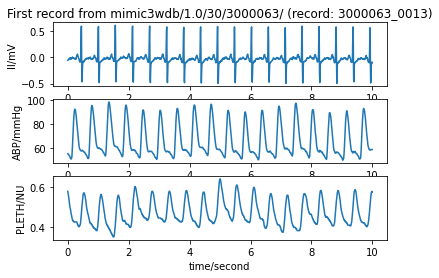

In [2]:
# Select the first record
selected_record = '3000063_0013'
database_name = 'mimic3wdb/1.0/30/3000063/'
print("Selected record: {}".format(selected_record))

# load data from this record
start_seconds = 20
no_seconds_to_load = 10
fs = 125
record_data = wfdb.rdrecord(record_name = selected_record, sampfrom = fs*start_seconds, sampto = fs*(start_seconds + no_seconds_to_load), pn_dir = database_name) 
print("{} seconds of data loaded from: {}".format(no_seconds_to_load, selected_record))

# Plot the data loaded from this record
title_text = "First record from " + database_name + " (record: " + selected_record + ")"
wfdb.plot_wfdb(record=record_data, title=title_text, time_units='seconds') 

# Separate records
Separate ECG, PPG and ABP signals

ECG at position 0
ABP at position 1
PPG at position 2


[Text(0.5, 0, 'Time [s]'), Text(0, 0.5, 'ABP')]

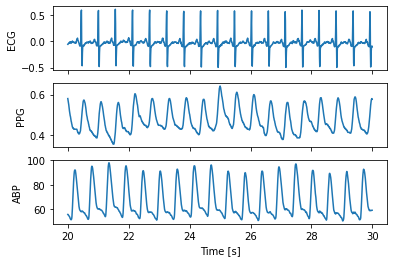

In [3]:
# ECG, PPG and ABP extraction
h = 0
for i in record_data.sig_name:
    if i == 'II':
        print('ECG at position ' + str(h))
        ecg = record_data.p_signal[:,h]
    elif i == 'PLETH':
        print('PPG at position ' + str(h))
        ppg = record_data.p_signal[:,h]
    elif i == 'ABP':
        print('ABP at position ' + str(h))
        abp = record_data.p_signal[:,h]
    else:
        print('Other signal (' + i + ') at position ' + str(h))
    h = h + 1

t = np.arange(start_seconds,(start_seconds + no_seconds_to_load),1.0/fs)

fig, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex = True, sharey = False)
ax1.plot(t, ecg)
ax1.set(xlabel = '', ylabel = 'ECG')
ax2.plot(t, ppg)
ax2.set(xlabel = '', ylabel = 'PPG')
ax3.plot(t, abp)
ax3.set(xlabel = 'Time [s]', ylabel = 'ABP')

In [4]:
# Remove NaNs
x, = np.where(np.isnan(ecg))
if len(x) != 0:
    print('NaNs in ECG: ' + str(x))
    for i in x:
        ecg[i] = ecg[i - 1]
x, = np.where(np.isnan(ppg))
if len(x) != 0:
    print('NaNs in PPG: ' + str(x))
    for i in x:
        ppg[i] = ppg[i - 1]
x, = np.where(np.isnan(abp))
if len(x) != 0:
    print('NaNs in ABP: ' + str(x))
    for i in x:
        abp[i] = abp[i - 1]

# Filter data

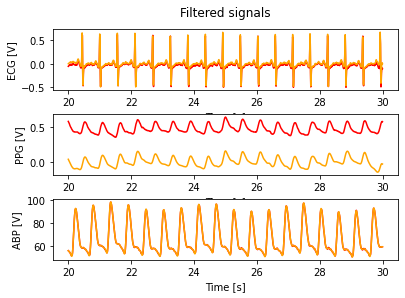

In [5]:
# Filter ECG
sos_ecg = sp.butter(10, [0.5, 40], btype = 'bp', analog = False, output = 'sos', fs = fs)
ecg_ff = sp.sosfiltfilt(sos_ecg, ecg)

# Filter PPG
sos_ppg = sp.butter(10, [0.2, 10], btype = 'bp', analog = False, output = 'sos', fs = fs)
ppg_ff = sp.sosfiltfilt(sos_ppg, ppg)

# Filter ABP
sos_abp = sp.butter(10, 10, btype = 'low', analog = False, output = 'sos', fs = fs)
abp_ff = sp.sosfiltfilt(sos_abp, abp)

fig, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex = False, sharey = False)
fig.suptitle('Filtered signals') 

ax1.plot(t, ecg, color = 'red')
ax1.plot(t, ecg_ff, color = 'orange')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('ECG [V]')

ax2.plot(t, ppg, color = 'red')
ax2.plot(t, ppg_ff, color = 'orange')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('PPG [V]')

ax3.plot(t, abp, color = 'red')
ax3.plot(t, abp_ff, color = 'orange')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('ABP [V]')

plt.subplots_adjust(left = 0.1,
                    bottom = 0.1, 
                    right = 0.9, 
                    top = 0.9, 
                    wspace = 0.4, 
                    hspace = 0.4)

#plt.show()

# QRS detection

## Define QRS detector functions

In [7]:
# QRS detection function
def qrs_detect(ecg,fs,w):
    """
    
    Description: QRS peak detection and correction
    Inputs:  ecg, array with ECG signal [user defined units]
             fs, sampling rate of signal [Hz]
             w, window length for analysis [s]
    Outputs: qrs, positions of R peaks [number of samples]
             n_int, number of intervals of length w in the signal
    
    Libraries: NumPy (as np), SciPy (Signal, as sp), Matplotlib (PyPlot, as plt)
    
    Version: 1.0 - June 2022
    
    Developed by: Elisa Mejía-Mejía
                   City, University of London
    
    """
    
    # Normalization of ECG
    ecg_n = (ecg - np.min(ecg))/(np.max(ecg) - np.min(ecg))
    ecg_n = ecg_n - np.mean(ecg_n)
    
    # Peak detection in windows of length w
    n_int = np.floor(len(ecg)/(w*fs))
    for i in range(int(n_int)):
        start = i*fs*w
        stop = (i + 1)*fs*w - 1
        #print('Start: ' + str(start) + ', stop: ' + str(stop))
        aux = ecg_n[range(start,stop)]
        locs, amps, nlocs = rpeakdetect(aux,fs,0.2)
        locs = locs + start
        if i == 0:
            qrs = locs
        else:
            qrs = np.append(qrs,locs)
    if n_int*fs*w != len(ecg_n):
        start = stop + 1
        stop = len(ecg_n)
        aux = ecg_n[range(start,stop)]
        if len(aux) > 20:
            locs, amps, nlocs = rpeakdetect(aux,fs,0.2)
            locs = locs + start
            qrs = np.append(qrs,locs)            
    
    # Peak correction
    # (1) Not peaks
    med_rr = np.median(np.diff(qrs))
    med_amp = np.median(ecg[qrs])
    pos_for = 0
    pos_rev = 0
    for i in range(len(qrs)):
        cur_amp = ecg[qrs[i]]
        if i == 1:                 # Peak is at the first position of the signal
            next_amp = ecg[qrs[i] + 1]
            cond = cur_amp >= next_amp
            #print(cur_amp, next_amp, cond)
        elif i == len(ecg):        # Peak is at the last position of the signal
            prev_amp = ecg[qrs[i] - 1]
            cond = cur_amp >= prev_amp
            #print(cur_amp, prev_amp, cond)
        else:   
            next_amp = ecg[qrs[i] + 1]
            prev_amp = ecg[qrs[i] - 1]
            cond = cur_amp >= prev_amp and cur_amp >= next_amp 
            #print(cur_amp, prev_amp, next_amp, cond)    
        
        if not(cond):
            # Forward search
            j = qrs[i] + 1
            if i == len(qrs) - 1:
                stop = len(ecg)
            else:
                stop = qrs[i + 1]
            while j < stop:
                cur_amp = ecg[j]
                next_amp = ecg[j + 1]
                prev_amp = ecg[j - 1]
                if not(cur_amp > next_amp and cur_amp > prev_amp):
                    j = j + 1
                else:
                    if ecg[j] >= 0.5*med_amp:
                        pos_for = j
                        j = stop
                    else:
                        j = j + 1
            # Reverse search
            j = qrs[i] - 1
            if i == 0:
                stop = 1
            else:
                stop = qrs[i - 1]
            while j > stop:
                cur_amp = ecg[j]
                next_amp = ecg[j + 1]
                prev_amp = ecg[j - 1]
                if not(cur_amp > next_amp and cur_amp > prev_amp):
                    j = j - 1
                else:
                    if ecg[j] >= 0.5*med_amp:
                        pos_rev = j
                        j = stop
                    else:
                        j = j - 1
            # Selection of peak
            if pos_for != 0 and pos_rev != 0:
                pos = [pos_for, pos_rev]
                if i - 1 == 0:
                    dif = - pos
                else:
                    dif = qrs[i - 1] - pos
                dif_med = np.abs(dif - med_rr)
                #print(dif_med)
                min_dif = np.min(dif_med)
                min_dif, = np.where(dif_med == min_dif)
                #print(min_dif,pos(min_ind))
                qrs[i] = pos(min_ind)
    
    # (2) Low peaks
    med_amp = np.median(ecg[qrs])
    #print(len(qrs))
    result, = np.where(ecg[qrs] < 0.5*med_amp)
    if len(result) > 0:
        #print(result)
        qrs = np.delete(np.array(qrs),result)
        #print(len(qrs)) 
    # (3) Too close or too far
    rr = np.diff(qrs)
    avg_rr = np.mean(rr)
    med_rr = np.median(rr)
    q3_rr, q1_rr = np.percentile(rr,[75, 25])
    iqr_rr = q3_rr - q1_rr
    #print(rr, avg_rr, med_rr, q3_rr, q1_rr, iqr_rr)
    if (med_rr < 0.5*fs or avg_rr < 0.5*fs) and (iqr_rr > 0.2*fs):
        result, = np.where(rr <= med_rr)
        qrs = np.delete(qrs, result)
        med_rr = np.median(rr)
    #   (a) Too close
    ind, = np.where(rr < 0.5*med_rr)
    if len(ind) != 0:
        i = 1
        while i <= len(ind):
            ind = no.sort(np.append(ind, ind[i] + 1))
            #print(ind)
            i = i + 2
        qrs = np.delete(qrs, ind)
    #   (b) Too far
    rr = np.diff(qrs)
    ind, = np.where(rr > 1.5*med_rr)
    th_amp = 0.5*np.median(ecg[qrs])
    #print(ind, th_amp)   
    if len(ind) != 0:
        i = 0
        while len(ind) != 0:
            #ind = np.round(ind)
            #qrs = np.round(qrs)
            #print(i, ind[i], len(qrs))
            if qrs[ind[i]] == qrs[-1]:
                aux = ecg[qrs[ind[i]]:len(ecg)]
            else:
                aux = ecg[qrs[ind[i]]:qrs[ind[i] + 1]]
            locs, _ = sp.find_peaks(aux)
            ind_del, = np.where(aux[locs] < th_amp)
            locs = np.delete(locs, ind_del)
            if len(locs) == 0:
                new = med_rr + qrs[ind[i]] - 1
            elif len(locs) == 1:
                new = locs + qrs[ind[i]] - 1
            else:
                aux_dif = np.abs(locs - med_rr)
                min_dif = np.min(aux_dif)
                ind_new, = np.where(aux_dif == min_dif)
                new = locs[ind_new] + qrs[ind[i]] - 1
            qrs = np.sort(np.append(qrs, new))
            rr = np.diff(qrs)
            ind, = np.where(rr > 1.5*med_rr)
    rr = np.diff(qrs)
    ind_del, = np.where(rr < 0.3*fs)
    rr = np.delete(rr, ind_del)
    
    #fig = plt.figure()
    #plt.plot(ecg, color = 'black')
    #plt.scatter(qrs,ecg[qrs],marker = 'o',color = 'red')
        
    return qrs, n_int

In [8]:
# R peak detect
def rpeakdetect(ecg, fs, th):
    """
    
    Description: QRS peak detection based on rpeakdetect2.m by G. Clifford
                 A batch QRS detector based upon that of Pan, Hamilton and Tompkins:
                 J. Pan & W. Tompkins. A real-time QRS detection algorithm. IEEE Trans Biomed Eng, vol. BME-32 NO. 3. 1985.
                 P. Hamilton & W. Tompkins. Quantitative Investigation of QRS Detection Rules Using the MIT/BIH Arrythmia 
                 Database. IEEE Trans Biomed Eng, vol. BME-33, NO. 12.1986.
    Inputs:  ecg, array with ECG signal [user defined units]
             fs, sampling rate of signal [Hz]
             th, threshold for peaks in integrated waveform - Default: 0.2
    Outputs: locs, positions of R peaks [number of samples]
             amps, amplitudes of R peaks [user defined units]
             nlocs, number of R peaks found
    
    Libraries: NumPy (as np), SciPy (Signal, as sp), Matplotlib (PyPlot, as plt)
    
    Version: 1.0 - June 2022
    
    Developed by: Elisa Mejía-Mejía
                  City, University of London
    
    """
    
    # Create time array
    t = np.divide(range(0,len(ecg) - 1), fs)
    
    # Preprocessing:
    # (1) Filter data
    sos = sp.butter(6, 40, btype = 'low', analog = False, output = 'sos', fs = fs)
    ecg_f = sp.sosfiltfilt(sos, ecg)
    # (2) Differentiate ECG
    ecg_d = np.diff(ecg_f)
    # (3) Square ECG
    ecg_s = ecg_d*ecg_d
    # (4) Integrate data
    if fs >= 256:
        d = np.ones(int(np.round(7*fs/256)))
    else:
        d = np.ones(21)
    ecg_fir = sp.lfilter(d, 1, ecg_s)
    ecg_med = sp.medfilt(ecg_fir, kernel_size = 9)
    
    # Remove filter delay:
    delay = np.ceil(len(d)/2)
    ecg_med = ecg_med[int(delay):len(ecg_med)]
    
    # Find peaks: 
    # (1) Find highest bumps in data
    start_int = round((len(ecg) - 1)/4)
    stop_int = round(3*(len(ecg) - 1)/4)
    max_h = np.max(ecg_med[start_int:stop_int])
    # (2) Determine left and right boundaries
    ecg_med = np.insert(ecg_med,0,0)
    ecg_med = np.append(ecg_med,0)
    n_left = 0
    n_right = 0
    for i in range(len(ecg_med)):
        if i > 0 and i < len(ecg_med):
            if ecg_med[i] > (th*max_h) and ecg_med[i - 1] < (th*max_h): # left boundary
                if n_left == 0:
                    left_bound = i - 1
                    n_left = 1
                else:
                    left_bound = np.append(left_bound,i - 1)
            if ecg_med[i] > (th*max_h) and ecg_med[i + 1] < (th*max_h): # right boundary
                if n_right == 0:
                    right_bound = i - 1
                    n_right = 1
                else:
                    right_bound = np.append(right_bound,i - 1)        
    #print(left_bound)
    #print(right_bound)
    # (4) Look through all possibilities
    if left_bound[0] > right_bound[0]:
        right_bound = np.delete(right_bound,0)
    if left_bound[-1] > right_bound[-1]:
        left_bound = np.delete(left_bound,0)
    nlocs = 0
    for i in range(len(left_bound)):
        #print(i)
        lb = left_bound[i]
        rb, = np.where(np.array(right_bound) > lb)
        if len(rb) != 0:
            rb = right_bound[rb[0]]
            #print(lb, rb)
            
            amp = np.max(ecg[lb:rb])
            pos, = np.where(np.array(ecg[lb:rb]) == np.amax(ecg[lb:rb]))
            pos = pos[0]
            pos = int(pos + lb)
            #print(pos, amp)
            if nlocs == 0:
                locs = pos
                amps = ecg[pos]
            else:
                locs = np.append(locs, pos)
                amps = np.append(amps, ecg[pos])
            nlocs = nlocs + 1
            #print(locs)
    
    #fig = plt.figure()
    #plt.plot(ecg)
    #plt.plot(ecg_f)
    #plt.plot(ecg_d)
    #plt.plot(ecg_s)
    #plt.plot(ecg_fir)
    #plt.plot(ecg_med)
    #plt.scatter(locs, amps, marker = 'o')
    
    return locs, amps, nlocs,

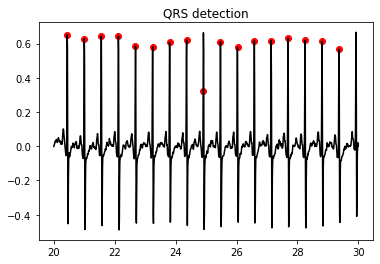

In [9]:
# Detect cardiac cycles
qrs, n_int = qrs_detect(ecg_ff,fs,5)

fig = plt.figure()
plt.title('QRS detection') 
plt.plot(t, ecg_ff, color = 'black')
plt.scatter(start_seconds + qrs/fs, ecg_ff[qrs], color = 'red', marker = 'o')